In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms, models
from torchvision.models import VGG19_Weights

%matplotlib inline

### Load the VGG19 model from pytorch

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.vgg19(weights=VGG19_Weights.DEFAULT).features

for param in model.parameters():
    param.requires_grad_(False)

model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Do the processing to data

In [4]:
def load_image(img_path, max_size=400, shape=None):
    img = Image.open(img_path)

    if max(img.size) > max_size:
      size = max_size
    else:
      size = max(img.size)
    
    if shape is not None:
      size = shape

    img_transform = transforms.Compose([
        transforms.Resize((size, int(1.5*size))),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))
    ])

    image = img_transform(img)[:3, :, :].unsqueeze(0)

    return image

Read the image & Pass to the function load_image </br>
Can change the style and content image in this section

In [5]:
content = load_image(img_path ="contentimg/ancient_city.jpg").to(device)
style = load_image(img_path ="styleimg/bfmosaic.jpg").to(device)

### Display the content & style image

In [6]:
def im_convert(img_tensor):
    image = img_tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

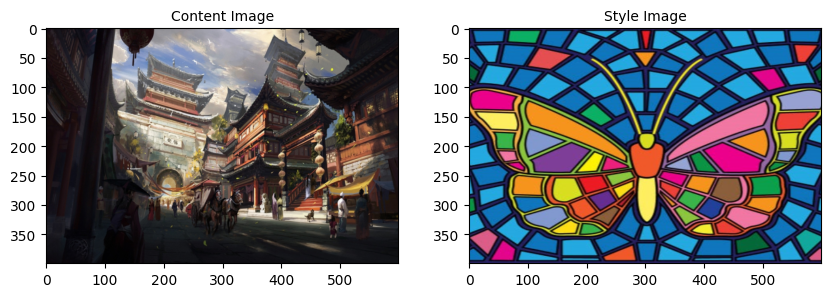

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(im_convert(content))
ax1.set_title("Content Image", fontsize=10)

ax2.imshow(im_convert(style))
ax2.set_title("Style Image", fontsize=10)

plt.show()

### Set the intermediate layers for Content & Style

In [ ]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = { # 0, 5, 10, 19, 28 is Style Extraction
            '0': 'conv1_1',
            '5': 'conv2_1', 
            '10': 'conv3_1', 
            '19': 'conv4_1',
            '30': 'conv5_2', # Content Extraction
            '28': 'conv5_1'
        }

    features = {}
    x = image
    for name, layer, in model._modules.items():
      x = layer(x)
      if name in layers:
        features[layers[name]] = x
    
    return features

### Set the Loss Function & Assign the Weights

In [ ]:
def gram_matrix(img_tensor):
    _, d, h, w = img_tensor.size()
    img_tensor = img_tensor.view(d, h * w)
    gram = torch.mm(img_tensor, img_tensor.t())

    return gram

# Set the loss function
content_features = get_features(content, model)
style_features = get_features(style, model)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

target = content.clone().requires_grad_(True).to(device)

Assign the weights

In [ ]:
style_weights = {
      'conv1_1': 1,
      'conv2_1': 0.75,
      'conv3_1': 0.5,
      'conv4_1': 0.25,
      'conv5_1': 0.25
}

content_weight = 1e-2
style_weight = 1e9

### Train the model

Total loss:  776759017472.0


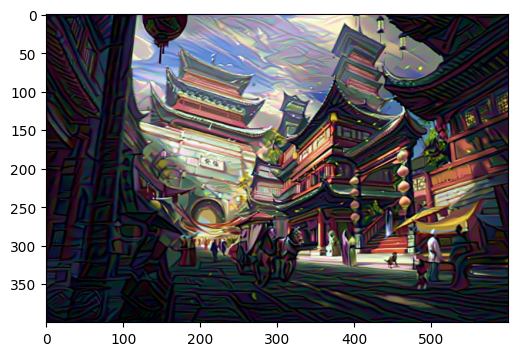

Total loss:  469024276480.0


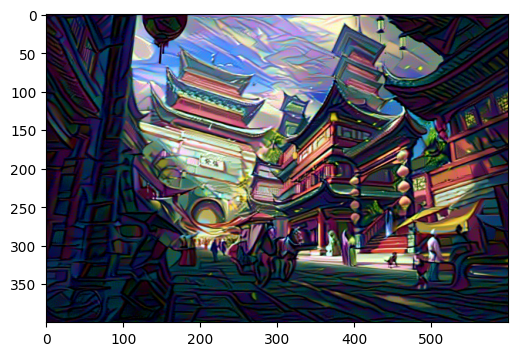

Total loss:  263252262912.0


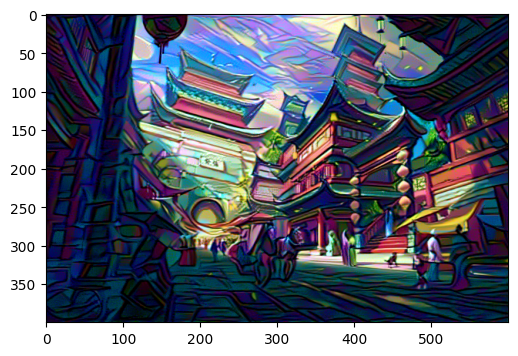

Total loss:  145658626048.0


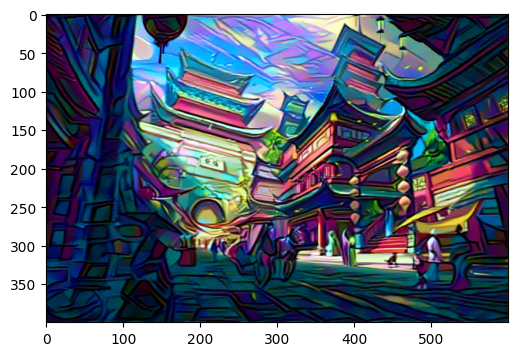

Total loss:  96188645376.0


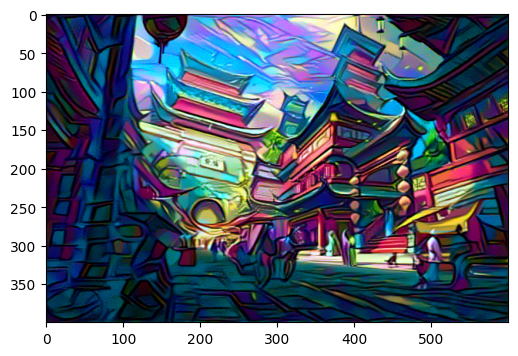

Total loss:  70264545280.0


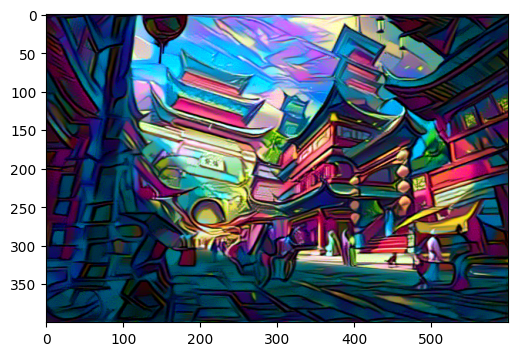

Total loss:  53140324352.0


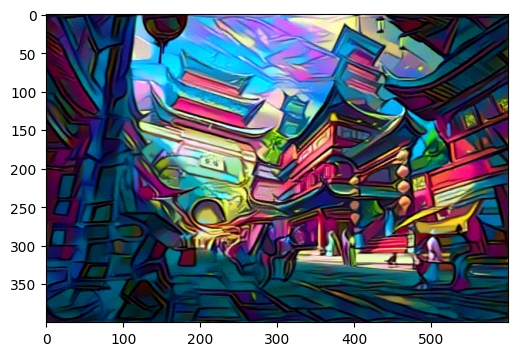

Total loss:  41107968000.0


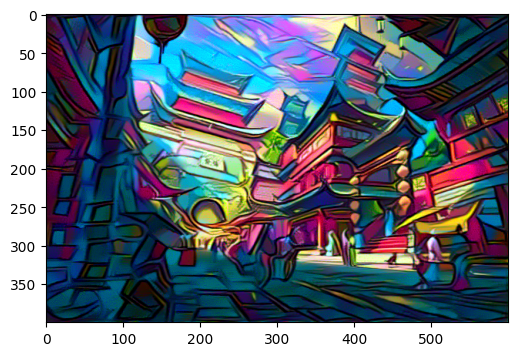

Total loss:  32453990400.0


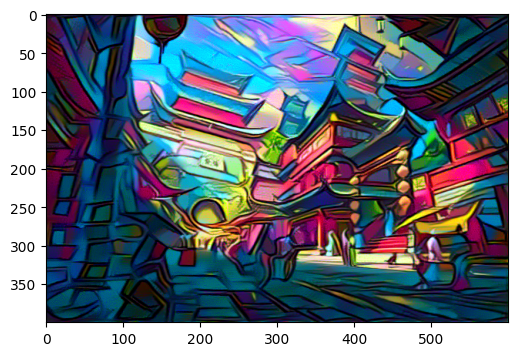

Total loss:  26179368960.0


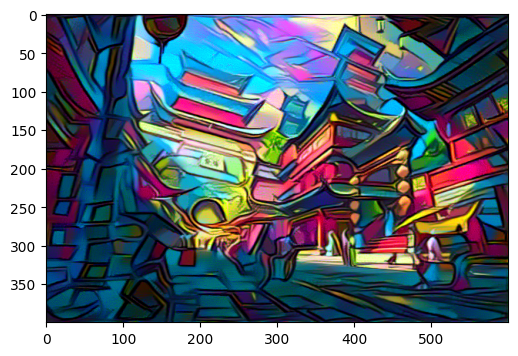

Total loss:  21411672064.0


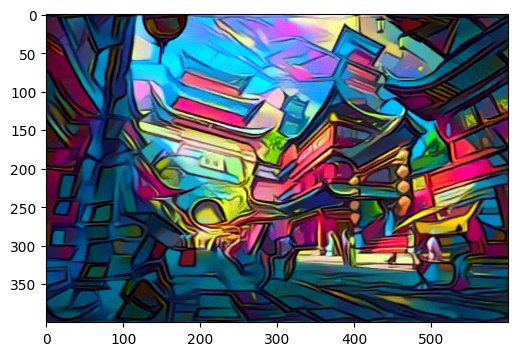

Total loss:  17706805248.0


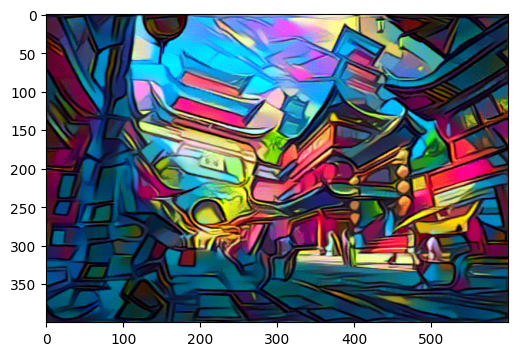

In [ ]:
show = 400

optimizer = torch.optim.Adam([target], lr=0.002)
steps = 5000

for i in range(1, steps+1):
    target_features = get_features(target, model)
    content_loss = torch.mean((target_features['conv5_2'] - content_features['conv5_2'])**2)

    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)
        
    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if i % show == 0:
        plt.figure(figsize=(8,4))
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

final_img = im_convert(target)

### Show the results & Save the Image

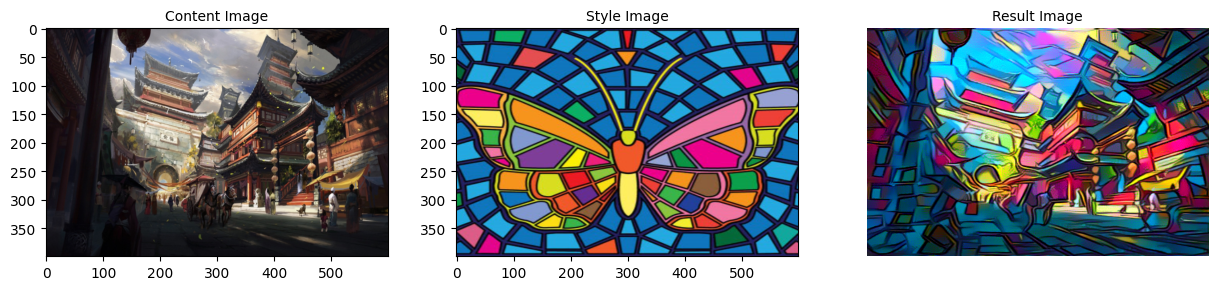

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(im_convert(content))
ax1.set_title("Content Image", fontsize=10)

ax2.imshow(im_convert(style))
ax2.set_title("Style Image", fontsize=10)

ax3.imshow(final_img)
ax3.set_title("Result Image", fontsize=10)
plt.axis('off')

plt.show()

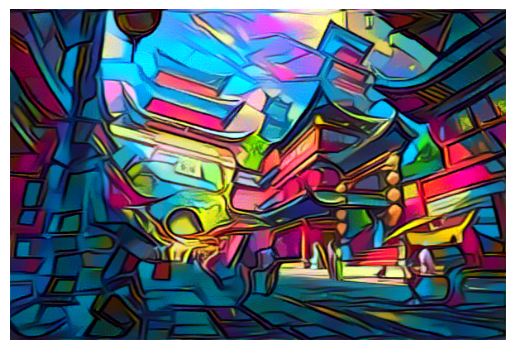

In [ ]:
from pathlib import Path
RESULTS_PATH = Path("results")
RESULTS_PATH.mkdir(parents=True, exist_ok=True)

plt.imshow(final_img)
plt.axis('off')
plt.savefig('results/results_img.png')

### Saving the model

In [ ]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "abstract.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/abstract.pth
